In [1]:
import csv
import matplotlib.pyplot as plt
import datetime

# 地盤の計算

地盤表面の温度は以下の式で表される。

$
\displaystyle
T_{surf,t} = \phi_{A,0} \times q_t + \sum_{m=1}^M T'_{surf,A,m,t} + \phi_{T,0} \times T_{g,t} + \sum_{m=1}^M T'_{surf,T,m,t}
$

$
\displaystyle
T'_{surf,A,m,t} = \phi_{1,A,m} \times q_{t-1} + r_m \times T'_{surf,A,m,t-1}
$

$
\displaystyle
T'_{surf,T,m,t} = \phi_{1,T,m} \times T_{g,t-1}+ r_m \times T'_{surf,T,m,t-1}
$

$T_{surf}$: 土間表面温度, <sup>o</sup>C  
$q$: 表面熱流, W m<sup>-2</sup>  
$T_g$: 土壌の境界温度, <sup>o</sup>C  
$\phi_{A,0}$: 吸熱応答の初項, m<sup>2</sup> K W<sup>-1</sup>  
$\phi_{T,0}$: 貫流応答の初項  
$\phi_{1,A,m}$: 指数項別吸熱応答係数, m<sup>2</sup> K W<sup>-1</sup>  
$\phi_{1,T,m}$: 指数項別貫流応答係数  
$r_m$: 公比

$
q_t = h \times ( T_{space,t} - T_{surf,t} )
$

$T_{space}$: 床下空間の温度, <sup>o</sup>C  
$h$: 表面熱伝達率, W m<sup>-2</sup> K<sup>-2</sup>

ここで、$T_{surf,t}$について解くと、次式となる。  

$
\displaystyle
T_{surf,t} = \frac { h \times \phi_{A,0} \times T_{space,t} + \sum_{m=1}^M T'_{surf,A,m,t} + \phi_{T,0} \times T_{g,t} + \sum_{m=1}^M T'_{surf,T,m,t} }{ 1 + h \times \phi_{A,0} }
$

ここで、$T'_{surf,T,m,t}$は、

$
\displaystyle
\begin{array}{ll}
T'_{surf,T,m,t} & = \phi_{1,T,m} \times T_{g,t-1} + r_m \times T'_{surf,T,m,t-1} \\
& = \phi_{1,T,m} \times T_{g,t-1}+ r_m \times \left( \phi_{1,T,m} \times T_{g,t-2} + r_m \times T'_{surf,T,m,t-2} \right) \\
& = \sum_{k=0}^\infty \phi_{1,T,m} \times r_m^k \times T_{g,t-(k+1)}
\end{array}
$

と書ける。$T_{g,t}$は土壌の境界温度であり、土壌の境界温度は常に一定かつ年平均気温に等しいとすると、

$
\displaystyle
T_{g,t} = T_{g,ave}
$

となり、

$
\displaystyle
T'_{surf,T,m,t} = \phi_{1,T,m} \times T_{g,ave} \times \sum_{k=0}^\infty r_m^k
$

$
\displaystyle
\phi_{T,0} \times T_{g,t} + \sum_{m=1}^M T'_{surf,T,m,t} = \phi_{T,0} \times T_{g,ave} + \sum_{m=1}^M \left( \phi_{1,T,m} \times T_{g,ave} \times \sum_{k=0}^\infty r_m^k \right ) 
$

ここで、

$
\displaystyle
\phi_{T,0} + \sum_{m=1}^M \left( \phi_{1,T,m} \times \sum_{k=0}^\infty r_m^k \right ) = 1
$

なので、

$
\displaystyle
\phi_{T,0} \times T_{g,t} + \sum_{m=1}^M T'_{surf,T,m,t} = T_{g,ave}
$

となる。従って、最終的に任意の時刻$t$における地盤の表面温度は

$
\displaystyle
T_{surf,t} = \frac { h \times \phi_{A,0} \times T_{space,t} + \sum_{m=1}^M T'_{surf,A,m,t} + T_{g,ave} }{ 1 + h \times \phi_{A,0} }
$

$
\displaystyle
T'_{surf,A,m,t} = \phi_{1,A,m} \times q_{t-1} + r_m \times T'_{surf,A,m,t-1}
$

となる。

In [2]:
class GroundTemp():
    
    def __init__( self, T_g_ave, phi_A0, phi_A1, r ):
        if len(phi_A1) != len(r):
            raise Exception('phi_A1 と r の項数が異なります。')
        self._T_g_ave  = T_g_ave
        self._phi_A0   = phi_A0
        self._phi_A1   = phi_A1
        self._r        = r
        self._q_surf   = 0.0
        self._T_surf_A = [0.0] * len(self._phi_A1)
        self._T_surf   = 0.0
    
    def updateTemp( self, h, T_space ):
        
        T_surf_A_new = [ phi_A1_m * self._q_surf + r_m * T_surf_A_m
                        for phi_A1_m, r_m, T_surf_A_m in zip( self._phi_A1, self._r, self._T_surf_A ) ]
        
        T_surf_new = ( h * self._phi_A0 * T_space + sum( T_surf_A_new ) + self._T_g_ave ) / ( 1 + h * self._phi_A0 )
        
        q_surf_new = h * ( T_space - T_surf_new )
        
        self._T_surf, self._q_surf, self._T_surf_A = T_surf_new, q_surf_new, T_surf_A_new
    
    def getSurfTemp( self ):
        return self._T_surf

In [3]:
class Row():
    
    def __init__( self, datas, columns ):
        
        for colum in columns:
            index = colum[0]
            tytle = colum[1]
            func  = colum[2]
            try:
                setattr( self, tytle, func( datas[index] ) )
            except:
                setattr( self, tytle, 'error' )
                raise ValueError(index)


In [4]:
class CSVData():
    
    def __init__( self, filename, columns ):
        
        self.rows = []
        
        with open( filename, 'r', encoding = 'shift-jis' ) as f:
            reader = csv.reader( f, delimiter = ',', quotechar = '"' )
            header = next( reader )
            
            for i, r in enumerate(reader):
                try:
                    self.rows.append( Row(r, columns ) )
                except ValueError as e:
                    print( '値が読み込めませんでした。:' + str(i) + '行目' + str(e) + '列目' )

In [5]:
datas = CSVData( 'space_temp.csv', [ 
    ( 0, 'datetime',  lambda x : datetime.datetime.strptime( x, '%Y/%m/%d %H:%M' ) ),
    ( 3, 'outTemp',   lambda x : float(x) ),
    ( 4, 'crawlTemp', lambda x : float(x) ),
    ( 5, 'surfTemp',  lambda x : float(x) ),
    ( 6, 'heatflow',  lambda x : float(x) ),
] )

値が読み込めませんでした。:1261行目3列目
値が読み込めませんでした。:5462行目3列目
値が読み込めませんでした。:5463行目3列目


In [6]:
gt = GroundTemp( T_g_ave = 8.788409273,
                 phi_A0  = 0.026999775,
                 phi_A1  = [ -0.0000000538985, 0.00000103123, -0.000013185, 0.000615251, 0.000353372, 0.002822011, 0.01866059, -0.013547161, 0.026262083, -0.023028152 ],
                 r       = [ 0.999996185, 0.99998474, 0.999938962, 0.99975593, 0.999023877, 0.996101618, 0.984491515, 0.939413063, 0.778800783, 0.367879441 ],
               )

y1s = []

for r in datas.rows:
    gt.updateTemp( 19.0, r.crawlTemp )
    y1s.append( gt.getSurfTemp() )
    
xs  = [ r.datetime for r in datas.rows ]
y2s = [ r.crawlTemp for r in datas.rows ]


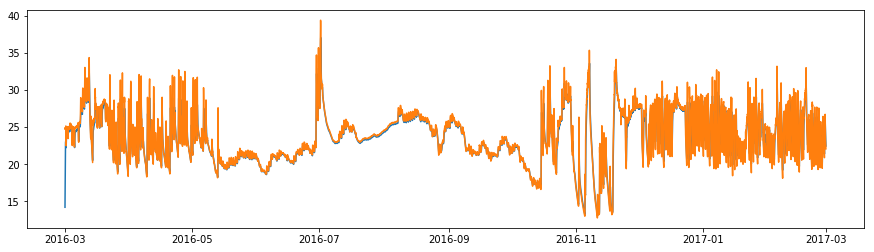

In [7]:
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)

ax.plot( xs, y1s )
ax.plot( xs, y2s )
plt.show()


# 省エネ基準における床下熱バランス式への適用

床下の熱バランスは以下のように表される。

$$
\displaystyle
\rho_{air} \times Cp_{air} \times V_A \times (\theta_{ex,d,t} - \theta_{uf,d,t} ) \div 3.6 + A_{s,ufvnt,A} \times U_s \times ( \theta_{in,d,t} - \theta_{uf,d,t} )
+ A_{s,ufvnt,A} \times U_{gf} \times ( \theta_{g,d,t} - \theta_{uf,d,t} ) + \psi \times L_{uf} \times ( \theta_{ex,d,t} - \theta_{uf,d,t} ) = 0
$$

この式を$\theta_{uf,d,t}$について解いたのが、現行の評価式(式(3))である。

$\rho_{air}$: 空気の密度, kg m<sup>-3</sup>  
$Cp_{air}$: 空気の比熱, kJ kg<sup>-1</sup> K<sup>-1</sup>  
$V_A$: 当該住戸の1時間当たりの換気量, m<sup>3</sup> h<sup>-1</sup>  
$U_{sv}$: 床の熱貫流率, W m<sup>-2</sup> K<sup>-1</sup>  
$U_{gf}$: 地盤の熱貫流率, W m<sup>-2</sup> K<sup>-1</sup>  
$\psi$: 基礎の線熱貫流率, W m<sup>-2</sup> K<sup>-1</sup>  
$A_{s,ufvnt,A}$: 当該住戸の外気を導入する床下空間に接する床の面積の合計, m<sup>2</sup>  
$L_{uf}$: 当該住戸の外気を導入する床下空間の基礎外周長さ, m  
$\theta_{ex,d,t}$: 日付 $d$ の時刻tにおける外気温度, degree C  
$\theta_{uf,d,t}$: 日付 $d$ の時刻tにおける当該住戸の床下温度, degree C  
$\theta_{in,d,t}$: 日付 $d$ の時刻tにおける室内温度, degree C  
$\theta_{g,d,t}$: 日付 $d$ の時刻tにおける地盤温度, degree C  

一方で、今回の変更では、地盤から床下への熱取得を表す第3項、

$$ \displaystyle A_{s,ufvnt,A} \times U_{gf} \times ( \theta_{g,d,t} - \theta_{uf,d,t} ) $$

における地盤温度 $\theta_{g,d,t}$ (これは一定程度の深さのところの地盤の温度であり表面温度ではない。)に代わり、地盤(又はそれを覆う基礎、以下単に地盤という。)表面温度 $\theta_{g,surf,d,t}$ を用いて、地盤から床下への熱取得を、

$$ \displaystyle q_{g,d,t} = A_{s,ufvnt,A} \times \alpha_g \times (\theta_{g,surf,d,t} - \theta _{uf,d,t} ) $$

で表す。ここで、

$q_{g,d,t}$: 日付 $d$ の時刻 $t$ における地盤から床下への熱移動, W  
$\alpha_g$: 地盤の表面熱伝達率, W m<sup>-1</sup> K<sup>-1</sup>  
$\theta_{g,surf,d,t}$: 日付 $d$ の時刻 $t$ における地盤の表面温度, degree C

である。また、$\theta_{g,surf,d,t}$は次のように表される。

$$ \displaystyle \theta_{g,surf,d,t} = \frac{ ( \alpha_g \times \phi_{A,0} \times \theta_{uf,d,t} + \Sigma_{m=1}^M \theta'_{surf,A,m,d,t} + T_{g,ave} ) }{ ( 1 + \alpha_g \times \phi_{A,0} ) } $$

$$ \displaystyle \theta'_{surf,A,m,d,t} = \phi_{1,A,m} \times q_{g,d,t-1} +r_m \times \theta'_{surf,A,m,d,t-1} $$

ここで、

$\psi_{A,0}$: 吸熱応答の初項, m<sup>2</sup> K W<sup>-1</sup>  
$\psi_{1,A,m}$: 指数項$m$における吸熱応答係数, m<sup>2</sup> K W<sup>-1</sup>  
$r_m$: 指数項$m$における公比  
$T_{g,ave}$: 地盤の不易層温度, degree C

である。$\psi_{A,0}$、$\psi_{1,A,m}$、$r_m$ は、地盤の層構成(地盤の深さ、土の熱伝導率・熱容量、地盤を覆うべた基礎等の層の熱物性(熱伝導率・熱容量)など)が決まれば決定される係数である。$T_{g,ave}$ は便宜的に年間平均温度とし、地域区分に依存した値となる。

$$
\begin{array}{ll}
\displaystyle 
q_{g,d,t} &= A_{s,ufvnt,A} \times \alpha_g \times ( \frac{ \alpha_g \times \phi_{A,0} \times \theta_{uf,d,t} + \Sigma_{m=1}^M \theta'_{surf,A,m,d,t} + T_{g,ave} }{ 1 + \alpha_g \times \phi_{A,0} } - \theta_{uf,d,t} ) \\
&= A_{s,ufvnt,A} \times \alpha_g \times \frac{ \Sigma_{m=1}^M \theta'_{surf,A,m,d,t} + T_{g,ave} - \theta_{uf,d,t} }{ 1 + \alpha_g \times \phi_{A,0} }
\end{array}
$$

この式でバランス式を書き換えると、


$$ \displaystyle
\rho_{air} \times Cp_{air} \times V_A \times ( \theta_{ex,d,t} - \theta_{uf,d,t}  ) \div 3.6 + A_{s,ufvnt,A} \times U_s \times ( \theta_{in,d,t} - \theta_{uf,d,t} ) 
+ A_{s,ufvnt,A} \times \alpha_g \times \frac{ \Sigma_{m=1}^M \theta'_{surf,A,m,d,t} + T_{g,ave} - \theta_{uf,d,t} }{ 1 + \alpha_g \times \phi_{A,0} } + \psi × L_{uf} \times ( \theta_{ex,d,t} - \theta_{uf,d,t} ) = 0 
$$

となる。$ \theta_{uf,d,t} $ について解くと、


$$
\begin{array}{ll}
\displaystyle
\theta_{uf,d,t} &= \left( \rho_{air} \times Cp_{air} \times V_A \times \theta_{ex,d,t} \div 3.6 + A_{s,ufvnt,A} \times U_s \times \theta_{in,d,t} \right. \\
& \left. + A_{s,ufvnt,A} \times \alpha_g \times \frac{ \sigma_(m=1)^M \theta'_{surf,A,m,d,t} + T_{g,ave} }{ 1 + \alpha_g \times \phi_{A,0} } + \psi \times L_{uf} \times \theta_{ex,d,t} \right) \\
&\div \left( \rho_{air} \times Cp_{air} \times V_A \div 3.6 + A_{s,ufvnt,A} \times U_s + A_{s,ufvnt,A} \times \alpha_g \times \frac{ 1 }{ 1 + \alpha_g \times \phi_{A,0} } + \psi \times L_{uf} \right)\\
\end{array} $$

 となる。ここで、$\rho_{air}$・$Cp_{air}$・$V_A$・$\theta_{ex,d,t}$・$A_{s,ufvnt,A}$・$U_s$・$\theta_{in,d,t}$・$\alpha_g$・$T_{g,ave}$・$\phi_{A,0}$・$\psi$・$L_{uf}$ は既知の値である。唯一未定な、 $\theta'_{surf,A,m,d,t}$ は、以下のように表される。



$$ \theta'_{surf,A,m,d,t} = \phi_{1,A,m} \times q_{g,d,t-1} + r_m \times \theta'_{surf,A,m,d,t-1} $$

ここで、$ \phi_{1,A,m}$・$r_m$ は既知の値である。$q_{g,d,t-1}$ は以下の式で表される。

$$ \displaystyle q_{g,d,t-1} = A_{s,ufvnt,A} \times \alpha_g \times \frac{ \Sigma_{m=1}^M \theta'_{surf,A,m,d,t-1} + T_{g,ave} - \theta_{uf,d,t-1} }{ 1 + \alpha_g \times \phi_{A,0} } $$

である。ここで未知数なのは、$ \theta_{uf,d,t-1}$ と $ \theta'_{surf,A,m,d,t-1} $ であるが、それぞれ前の時刻の値を用いることとなる。ここで、$ \theta_{uf,d,t-1} $ と $ \theta'_{surf,A,m,d,t-1} $ の初期値が問題となるため、一般的に地盤の助走計算は3年程度必要とされているが、今回の計算では不易層を3mと比較的浅くとっているため、助走計算は1年程度で良いものと思われる。(助走計算を何年とすべきかは計算精度との兼ね合いであり、年間エネルギー消費量を求めるという目的の省エネ基準の計算においては、1年程度が限界かと思われる。)